In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPU')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found, training will default to CPU.")

No GPU found, training will default to CPU.


In [13]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import shutil
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

In [4]:
import os
#Check number of images in each folder
path = "/content/drive/MyDrive/KaggleData/Image_Dataset/"
dir_list = [os.path.join(path,i) for i in os.listdir(path) if os.path.isdir(os.path.join(path,i))]
size_dict = {}
for i,value in enumerate(dir_list):
    size_dict[os.listdir(path)[i]] = len(os.listdir(value))
size_dict

{'Benign': 2480, 'Malignant': 5429}

In [ ]:
#Checking the len
len(os.listdir("/content/drive/MyDrive/KaggleData/Image_Dataset/"))

2

In [5]:
#Function to read the dataset from a specified directory
def import_images(folder,target):
    images = []
    for item in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,item), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            images.append([img,target])
    return images

In [6]:
#Importing the dataset from the specified directory using the created function and assign them with labels
#Where 0 is for Benign, and 1 is for Malignant
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign",0)
malignant = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant",1)

In [7]:
full_data = benign + malignant  # Create a new list containing elements of both

In [8]:
import pickle

# Save the full dataset using Pickle
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'wb') as f:
    pickle.dump(full_data, f)
print("Dataset saved successfully!")


Dataset saved successfully!


In [9]:
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Dataset successfully loaded.")
print(f"Total number of samples in the dataset: {len(loaded_data)}")

Dataset successfully loaded.
Total number of samples in the dataset: 7909


In [10]:
benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Benign", 0)  # Call your function

# # Check the type of the entire returned dataset
print(type(benign))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(benign[0]))

    benign = import_images("/content/drive/MyDrive/KaggleData/Image_Dataset/Malignant", 1)  # Call your function

# # Check the type of the entire returned dataset
print(type(malignant))

# # Check the type of the first element within the dataset
if benign:  # Check if the list is not empty
    print(type(malignant[1]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


Spliting Data/Stratification: to ensure each split maintains a label
distribution similar to the original dataset (particularly important for imbalanced datasets) to ensure that both validation and test sets are representative of the overall dataset, supporting more reliable evaluation and tuning of my model.

In [11]:
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you have a list of tuples (image, label)
full_images = np.array([item[0] for item in full_data])  # Extract images
full_labels = np.array([item[1] for item in full_data])  # Extract labels for stratification

# Perform the dataset splitting into training and test set (with stratification)
train_images, test_images, train_labels, test_labels = train_test_split(
    full_images, full_labels, test_size=0.1, random_state=30, stratify=full_labels
)

# Extracting validation dataset from the training data (with stratification)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=(0.1/0.9), random_state=30, stratify=train_labels
)




Retinex theory, which includes Single-Scale Retinex (SSR) and Multi-Scale Retinex (MSR), is an alternative approach to stain normalization in histology and image processing. It aims to improve contrast and correct illumination to enhance image features. SSR applies a single scale for illumination correction, leading to more uniform lighting across an image. MSR combines different scales, which can enhance fine details to broader patterns. These methods can enhance the appearance of histological images, making them more suitable for visual inspection and computational analysis.

**MSRCR**

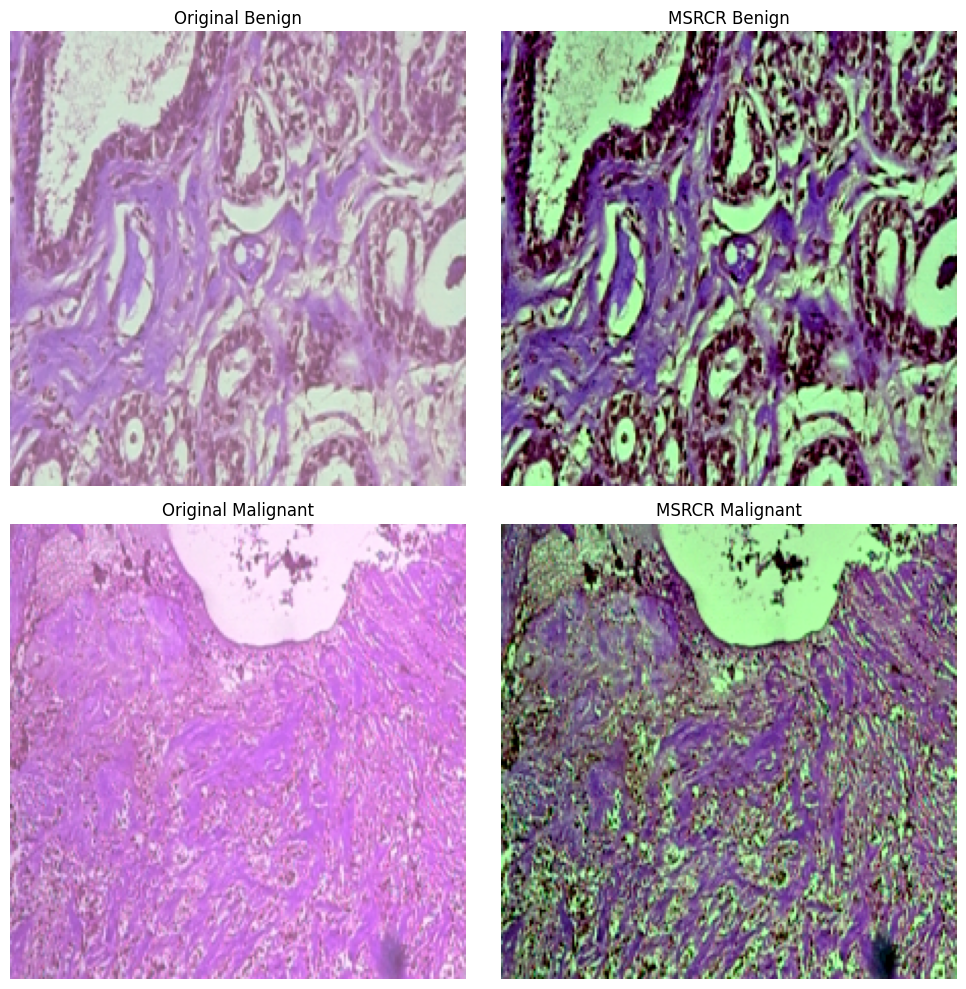

In [ ]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt

def msrcr(img, sigma_list, G, b, alpha, beta):
    """
    Apply Multi-Scale Retinex with Color Restoration to an image.

    Parameters:
    - img: Input image.
    - sigma_list: List of standard deviations for Gaussian blur.
    - G: Gain factor for the final image.
    - b: Offset value for brightness adjustment.
    - alpha: Gain control for color restoration.
    - beta: Strength of color restoration.

    Returns:
    - msrcr_img: Image after MSRCR processing.
    """
    img = np.float64(img) + 1.0
    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        retinex += np.log(img) - np.log(cv2.GaussianBlur(img, (0, 0), sigma))
    retinex /= len(sigma_list)

    img_sum = np.sum(img, axis=2, keepdims=True)
    color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))

    msrcr_img = G * (retinex * color_restoration + b)
    msrcr_img = np.clip(msrcr_img, 0, 255).astype(np.uint8)

    return msrcr_img

# Load dataset
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'rb') as file:
    full_data = pickle.load(file)

benign_images = [image for image, label in full_data if label == 0]
malignant_images = [image for image, label in full_data if label == 1]

if not benign_images:
    raise ValueError("No benign images found in the dataset.")
if not malignant_images:
    raise ValueError("No malignant images found in the dataset.")

# Select the first benign and malignant image
test_benign = benign_images[0]
test_malignant = malignant_images[0]

# MSRCR parameters
sigma_list = [15, 80, 250]  # Multi-scale standard deviations for Gaussian blur
G = 5.0  # Gain factor
b = 25.0  # Brightness offset
alpha = 125.0  # Color restoration gain control
beta = 46.0  # Color restoration strength

# Apply MSRCR to the test images
msrcr_test_benign = msrcr(test_benign, sigma_list, G, b, alpha, beta)
msrcr_test_malignant = msrcr(test_malignant, sigma_list, G, b, alpha, beta)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

titles = ['Original Benign', 'MSRCR Benign', 'Original Malignant', 'MSRCR Malignant']
images = [test_benign, msrcr_test_benign, test_malignant, msrcr_test_malignant]

for ax, img, title in zip(axes, images, titles):
    if img.shape[-1] == 3:  # Check for color image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.show()


APPLY MSRCR TO ALL IMAGES/SETS

NameError: name 'msrcr_test_benign' is not defined

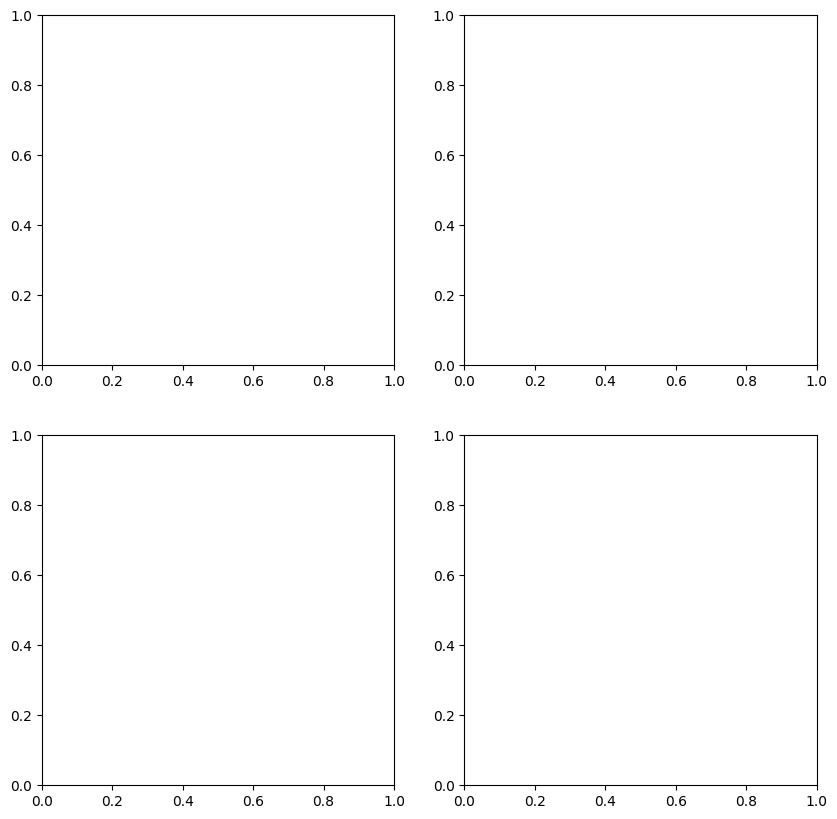

In [12]:
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt


def msrcr_batch(images, sigma_list, G, b, alpha, beta):
    """Applies MSRCR to a list or array of images."""

    def process_single_image(img):
        """
        Applies MSRCR to a single image.

        Parameters:
        - img: Input image.
        - sigma_list: List of standard deviations for Gaussian blur.
        - G: Gain factor for the final image.
        - b: Offset value for brightness adjustment.
        - alpha: Gain control for color restoration.
        - beta: Strength of color restoration.

        Returns:
        - msrcr_img: Image after MSRCR processing.
        """

        img = np.float64(img) + 1.0
        retinex = np.zeros_like(img)
        for sigma in sigma_list:
            retinex += np.log(img) - np.log(cv2.GaussianBlur(img, (0, 0), sigma))
        retinex /= len(sigma_list)

        img_sum = np.sum(img, axis=2, keepdims=True)
        color_restoration = beta * (np.log10(alpha * img) - np.log10(img_sum))
        msrcr_img = G * (retinex * color_restoration + b)
        msrcr_img = np.clip(msrcr_img, 0, 255).astype(np.uint8)
        return msrcr_img

    return np.array([process_single_image(img) for img in images])

# Load dataset
with open('/content/drive/MyDrive/KaggleData/Image_Dataset/full_dataset.pkl', 'rb') as file:
    full_data = pickle.load(file)

benign_images = [image for image, label in full_data if label == 0]
malignant_images = [image for image, label in full_data if label == 1]

if not benign_images:
    raise ValueError("No benign images found in the dataset.")
if not malignant_images:
    raise ValueError("No malignant images found in the dataset.")

# Select the first benign and malignant image
test_benign = benign_images[0]
test_malignant = malignant_images[0]

# MSRCR parameters
# Apply MSRCR to each set (modify parameters as needed)
sigma_list = [15, 80, 250]
G = 5.0
b = 25.0
alpha = 125.0
beta = 46.0



import random
# Process images with MSRCR (this assumes the lists are properly defined)
train_images_processed = msrcr_batch(train_images, sigma_list, G, b, alpha, beta)
val_images_processed = msrcr_batch(val_images, sigma_list, G, b, alpha, beta)
test_images_processed = msrcr_batch(test_images, sigma_list, G, b, alpha, beta)

# # Corrected Visualization
# # For simplicity, let's just visualize a couple of processed test images alongside their originals
# fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjust for 2 original and 2 processed images
# axes = axes.ravel()

# sample_indices = random.sample(range(len(test_images)), 2)  # Randomly select 2 images for visualization

# for i, idx in enumerate(sample_indices):
#     original_img = test_images[idx]
#     processed_img = test_images_processed[idx]

#     # Display original image
#     ax = axes[2*i]
#     ax.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
#     ax.set_title(f'Original Image {idx}')
#     ax.axis('off')

#     # Display processed image
#     ax = axes[2*i + 1]
#     ax.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
#     ax.set_title(f'Processed Image {idx}')
#     ax.axis('off')

# plt.tight_layout()
# plt.show()



In [13]:
# Process the selected benign and malignant test images with MSRCR
msrcr_test_benign = msrcr_batch([test_benign], sigma_list, G, b, alpha, beta)[0]
msrcr_test_malignant = msrcr_batch([test_malignant], sigma_list, G, b, alpha, beta)[0]

# Now you can safely include these processed images in your visualization
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjust for 2 original and 2 processed images
axes = axes.ravel()

# Original and processed benign image
axes[0].imshow(cv2.cvtColor(test_benign, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Benign')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(msrcr_test_benign, cv2.COLOR_BGR2RGB))
axes[1].set_title('MSRCR Benign')
axes[1].axis('off')

# Original and processed malignant image
axes[2].imshow(cv2.cvtColor(test_malignant, cv2.COLOR_BGR2RGB))
axes[2].set_title('Original Malignant')
axes[2].axis('off')

axes[3].imshow(cv2.cvtColor(msrcr_test_malignant, cv2.COLOR_BGR2RGB))
axes[3].set_title('MSRCR Malignant')
axes[3].axis('off')

plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Save the processed data
import pickle

# After data are processed data in sets like:
# train_images_processed, val_images_processed, test_images_processed
# And corresponding labels:  train_labels, val_labels, test_labels

with open('/content/drive/MyDrive/KaggleData/processed_data.pkl', 'wb') as f:
    pickle.dump({
        'train_images': train_images_processed,
        'train_labels': train_labels,
        'val_images': val_images_processed,
        'val_labels': val_labels,
        'test_images': test_images_processed,
        'test_labels': test_labels
    }, f)

print("Dataset saved successfully!")

Dataset saved successfully!


In [21]:
with open('/content/drive/MyDrive/KaggleData/processed_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print("Dataset successfully loaded.")
print(f"Total number of samples in the dataset: {len(loaded_data)}")

Dataset successfully loaded.
Total number of samples in the dataset: 6


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Define how many images to visualize
num_images_to_visualize = 4

# Function to apply Z-score normalization per image
def z_score_normalization(image):
    image_normalized = (image - np.mean(image, axis=(0, 1), keepdims=True)) / np.std(image, axis=(0, 1), keepdims=True)
    # Rescale the normalized image to the range [0, 1]
    min_val = image_normalized.min(axis=(0, 1), keepdims=True)
    max_val = image_normalized.max(axis=(0, 1), keepdims=True)
    image_rescaled = (image_normalized - min_val) / (max_val - min_val)
    return image_rescaled

# Function to apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3 and image.shape[2] == 3:  # Color image
        # Convert to uint8 as CLAHE expects 8-bit input
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = np.empty_like(image_uint8)
        for i in range(3):  # Apply CLAHE to each channel
            clahe_img[:, :, i] = clahe.apply(image_uint8[:, :, i])
        # Convert back to float32 for consistency in processing and visualization
        clahe_img = clahe_img.astype(np.float32) / 255
        return clahe_img
    else:  # Grayscale image
        image_uint8 = (image * 255).astype(np.uint8)
        clahe_img = clahe.apply(image_uint8)
        return clahe_img.astype(np.float32) / 255

# Modified function to preprocess datasets and return both normalized and CLAHE images
def preprocess_datasets(images):
    normalized_images = np.zeros_like(images, dtype=np.float32)
    clahe_images = np.zeros_like(images, dtype=np.float32)
    for i, img in enumerate(images):
        normalized_img = z_score_normalization(img)
        normalized_images[i] = normalized_img
        clahe_img = apply_clahe(normalized_img)
        clahe_images[i] = clahe_img
    return normalized_images, clahe_images

# Assuming test_benign and test_malignant are defined and loaded correctly
test_benign_normalized, test_benign_clahe = preprocess_datasets([test_benign])
test_malignant_normalized, test_malignant_clahe = preprocess_datasets([test_malignant])

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2 rows for benign and malignant, 3 cols for original, normalized, and CLAHE

# Original Benign Image
axes[0, 0].imshow(cv2.cvtColor(test_benign, cv2.COLOR_BGR2RGB))
axes[0, 0].set_title("Original Benign")
axes[0, 0].axis("off")

# Normalized Benign Image
axes[0, 1].imshow(test_benign_normalized[0])
axes[0, 1].set_title("Normalized Benign")
axes[0, 1].axis("off")

# CLAHE Benign Image
axes[0, 2].imshow(test_benign_clahe[0])
axes[0, 2].set_title("CLAHE Benign")
axes[0, 2].axis("off")

# Original Malignant Image
axes[1, 0].imshow(cv2.cvtColor(test_malignant, cv2.COLOR_BGR2RGB))
axes[1, 0].set_title("Original Malignant")
axes[1, 0].axis("off")

# Normalized Malignant Image
axes[1, 1].imshow(test_malignant_normalized[0])
axes[1, 1].set_title("Normalized Malignant")
axes[1, 1].axis("off")

# CLAHE Malignant Image
axes[1, 2].imshow(test_malignant_clahe[0])
axes[1, 2].set_title("CLAHE Malignant")
axes[1, 2].axis("off")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

The Original Image columns show the initial state of the images with natural coloring and contrast.
The Normalized Image columns reflect the effect of Z-score normalization. The color balance has changed significantly due to the rescaling of pixel intensity values. The images have more contrast and appear brighter, which is expected since Z-score normalization adjusts the pixel values based on the image's mean and standard deviation.
The CLAHE Image columns demonstrate further enhancement in local contrast due to the CLAHE algorithm. The textures and structures within the images are more pronounced, and the images exhibit improved sharpness and detail.

From a visual inspection, the transformations seem to be appropriately applied and could potentially lead to better performance in subsequent image analysis or machine learning tasks. The CLAHE-transformed images do not look identical to the normalized ones, indicating that CLAHE is contributing to enhancing the image contrast beyond what Z-score normalization achieves.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

IMG_SIZE = 224  # Assuming this is the correct image size

# Load the processed dataset
with open('/content/drive/MyDrive/KaggleData/processed_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Extract datasets and labels
train_images_processed = data['train_images']
train_labels = data['train_labels']
val_images_processed = data['val_images']
val_labels = data['val_labels']
test_images_processed = data['test_images']
test_labels = data['test_labels']

# Data is already split into training, validation, and test sets,
# there is no need to perform a train/test split again.
# Directly apply RandomOverSampler on the training data
ros = RandomOverSampler(random_state=42)

# Reshaping is only necessary if your images are not already flattened for the RandomOverSampler
# Assuming your images are (224, 224, 3), you would reshape for RandomOverSampler like so:
training_data_reshaped = train_images_processed.reshape(-1, IMG_SIZE * IMG_SIZE * 3)

# Apply RandomOverSampler
training_data_resampled, training_labels_resampled = ros.fit_resample(training_data_reshaped, train_labels)

# Reshape the data back to its original shape after oversampling
training_dataset = training_data_resampled.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Note: Validation and test datasets do not need oversampling.
# You can directly use val_images_processed and test_images_processed as they are.

print(f"Training dataset size: {len(training_dataset)}")
print(f"Validation dataset size: {len(val_images_processed)}")
print(f"Test dataset size: {len(test_images_processed)}")


Training dataset size: 8686
Validation dataset size: 791
Test dataset size: 791


# Model Training

In [4]:
#Importing libraries needed for the modeling and training
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, Callback , ModelCheckpoint
from tensorflow.keras.metrics import Accuracy,binary_crossentropy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [5]:
#Setting the batch size for the cnn model
bs = 64

In [6]:
#Defining Image Data Generator for image augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     horizontal_flip=True,
#     vertical_flip=True,
#     shear_range=0.2,
#     fill_mode='nearest',
#     zoom_range=0.2,
#     brightness_range=[0.8, 1.2],  # Example color space augmentation
#     channel_shift_range=20  # Example for randomly shifting color channels
# )
#Defining Image Data Generator for image augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    fill_mode='nearest',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],  # Example color space augmentation
    channel_shift_range=20  # Example for randomly shifting color channels
)


# Custom CNN Model 1

In [7]:
#Defining the base model
cancer_model = Sequential()

#First Layer
cancer_model.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (224,224,3), activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Second Layer
cancer_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same',activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Third Layer
cancer_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.4))

#Fourth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))
cancer_model.add(Dropout(0.2))

#Fifth Layer
cancer_model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu'))
cancer_model.add(MaxPooling2D(pool_size = (2,2)))

#Flattening the layers
cancer_model.add(Flatten())

#Adding the dense layer
cancer_model.add(Dense(256, activation = 'relu'))
cancer_model.add(Dense(128, activation = 'relu'))
cancer_model.add(Dense(1, activation = 'sigmoid'))

cancer_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 27, 27, 128)       0

In [8]:
#Setting the learning rate to reduce gradually over the training period
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=20*50,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

In [9]:
#Compiling the model
cancer_model.compile(loss='binary_crossentropy', optimizer = get_optimizer(), metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=5)
# checkpoint = ModelCheckpoint("./Best_model/",save_best_only=True,)
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)

In [11]:
# Assume the datagen, rlrp, and bs have been defined earlier in your code
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load the processed dataset
with open('/content/drive/MyDrive/KaggleData/processed_data.pkl', 'rb') as file:
    data = pickle.load(file)

# # No need to reshape images here as we're using them directly with ImageDataGenerator
# Extract training, validation, and test datasets
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']
test_labels = data['test_labels']




        # Assuming cancer_model is your model that's ready to be trained
history = cancer_model.fit(datagen.flow(train_images, train_labels, batch_size=bs),
                           validation_data=(val_images, val_labels),
                           epochs=50,
                           callbacks=[rlrp],
                           verbose=1)
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/50
99/99 [==============================] - 87s 772ms/step - loss: 6.0017 - accuracy: 0.6736 - val_loss: 0.6134 - val_accuracy: 0.6865 - lr: 9.1075e-04
Epoch 2/50
99/99 [==============================] - 75s 759ms/step - loss: 0.5838 - accuracy: 0.6864 - val_loss: 0.5808 - val_accuracy: 0.6865 - lr: 8.3542e-04
Epoch 3/50
99/99 [==============================] - 76s 767ms/step - loss: 0.5699 - accuracy: 0.6869 - val_loss: 0.6127 - val_accuracy: 0.6865 - lr: 7.7160e-04
Epoch 4/50
99/99 [==============================] - 77s 773ms/step - loss: 0.5564 - accuracy: 0.7005 - val_loss: 0.5613 - val_accuracy: 0.7092 - lr: 7.1685e-04
Epoch 5/50
99/99 [==============================] - 76s 764ms/step - loss: 0.5468 - accuracy: 0.6956 - val_loss: 0.6111 - val_accuracy: 0.7016 - lr: 6.6934e-04
Epoch 6/50
99/99 [==============================] - 76s 764ms/step - loss: 0.5467 - accuracy: 0.7048 - val_loss: 0.5579 - val_accuracy: 0.6814 - lr: 6.2775e-04
Epoch 7/50
99/99 [======================

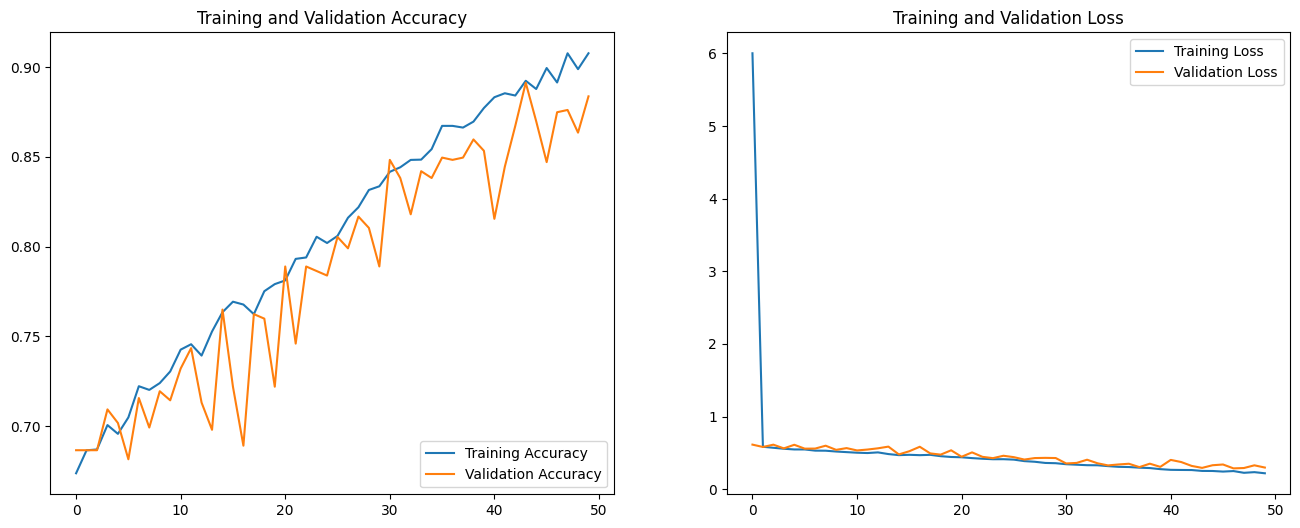

In [14]:
#Plotting the model results

#Getting the accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

#Getting the losses
loss = history.history['loss']
val_loss = history.history['val_loss']

#No of epochs it trained
epochs_range = history.epoch

#Plotting Training and Validation accuracy
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The training accuracy increases over time but with fluctuations, suggesting that the model is learning but also facing some variance issues with the validation set.
The training loss decreases as expected, but the validation loss is much more stable after an initial descent. The fact that it doesn't increase significantly is a positive sign, indicating there is no substantial overfitting.
There is a gap between the training and validation accuracy, suggesting some overfitting, although this gap is relatively sma

# Performance Evaluation of custom CNN model 1

Given my setup, as I want to evaluate the performance of my custom CNN model accurately, I should primarily use the validation set during the model development phase for tuning and early stopping, and finally, the test set for evaluating how well the model generalizes to new, unseen data. This approach ensures that my model's performance metrics reflect its ability to work with data it hasn't been trained on, which is a critical measure of its effectiveness in real-world applications.

In [21]:
import pickle

# Load the processed dataset
with open('/content/drive/MyDrive/KaggleData/processed_data.pkl', 'rb') as file:
    data = pickle.load(file)

# Extract datasets
train_images = data['train_images']
train_labels = data['train_labels']
val_images = data['val_images']
val_labels = data['val_labels']
test_images = data['test_images']  # Ensure this line is executed
test_labels = data['test_labels']


# Predictions on validation set
y_val_pred = cancer_model.predict(val_images)

# Evaluate performance on the validation set
# (You can use metrics like accuracy, confusion matrix, etc., as shown in the previous response.)

# After finalizing the model, predict on the test set
y_test_pred = cancer_model.predict(test_images)

# Evaluate performance on the test set
# This gives you an unbiased evaluation of your model's generalization capability


25/25 [==============================] - 0s 14ms/step


In [33]:
# print(y_test_pred)

In [35]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_test_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 

<ipython-input-35-d15972a3d86d>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_test_pred]


In [36]:
#Round up model prediction to 0 and 1 and convert result to an array
rounded = [float(np.round(x)) for x in y_test_pred]
rounded_predictions = np.asarray(rounded).astype(int)
print(rounded_predictions)

[1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1
 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1
 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0 1 0 0
 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0
 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 

<ipython-input-36-d15972a3d86d>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rounded = [float(np.round(x)) for x in y_test_pred]


In [37]:
#Classification report
print(classification_report(test_labels, rounded_predictions))

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       248
           1       0.89      0.93      0.91       543

    accuracy                           0.87       791
   macro avg       0.86      0.84      0.85       791
weighted avg       0.87      0.87      0.87       791



[[184  64]
 [ 37 506]]


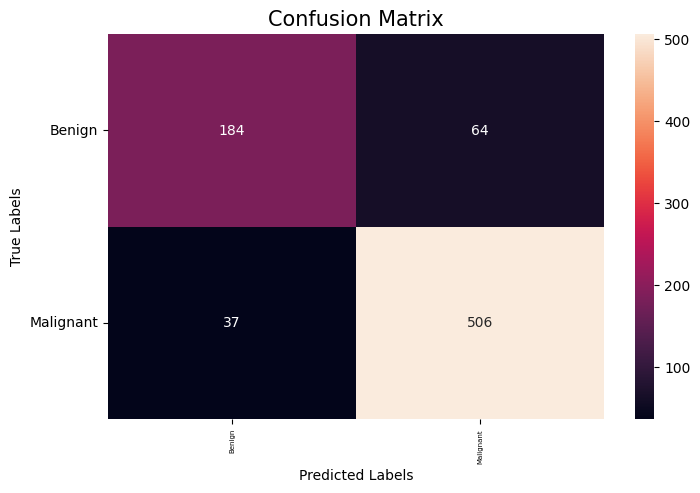

In [38]:
#Confusion matrix
cm = confusion_matrix(test_labels, rounded_predictions)
print(cm)

import seaborn as sns

#Setting the labels
labels = ['Benign', 'Malignant']

#Plot the Confusion matrix graph
fig= plt.figure(figsize=(8, 5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')
ax.set_xlabel('Predicted Labels', fontsize=10)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(labels, fontsize = 5)
ax.xaxis.tick_bottom()

ax.set_ylabel('True Labels', fontsize=10)
ax.yaxis.set_ticklabels(labels, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

The matrix has two classes: "Benign" and "Malignant."
The True Labels are on the y-axis (vertical), representing the actual class labels from the dataset.
The Predicted Labels are on the x-axis (horizontal), representing the labels predicted by the model.
Based on the values in the matrix:

True Positives for "Benign": 184 instances were correctly predicted as benign.
False Negatives for "Benign": 37 instances were incorrectly predicted as malignant when they were actually benign. These are Type II errors for the "Benign" class.
True Positives for "Malignant": 506 instances were correctly predicted as malignant.
False Positives for "Benign" (or Type I errors for the "Malignant" class): 64 instances were incorrectly predicted as benign when they were actually malignant.
Insights:
Model Sensitivity for "Malignant" Class: The model has high sensitivity (true positive rate) for the "Malignant" class, correctly identifying 506 out of 543 malignant instances (506 true positives + 37 false negatives).
Model Precision for "Benign" Class: The model has reasonable precision for the "Benign" class, with a lower false positive rate (64 instances were incorrectly labeled as benign).
Considerations for Performance:
Accuracy: How often the model predicts correctly for both classes.
Precision for "Malignant" Class: Of the instances predicted as malignant, how many were actually malignant.
Recall/Sensitivity for "Benign" Class: Of all the actual benign instances, how many were correctly identified as benign.
F1 Score: The harmonic mean of precision and recall, which provides a balance between the two for each class.
Further Steps:
To improve model performance, consider examining the false positives and false negatives more closely to understand why these errors are occurring.
Examine the characteristics of the misclassified examples to see if additional features or different data preprocessing might improve performance.
It may also be beneficial to consider model-specific hyperparameter tuning or alternative model architectures to address any potential bias or variance issues.

In [39]:
#Accuracy
accuracy = accuracy_score(test_labels, rounded_predictions)
print('Accuracy: %f' % accuracy)

Accuracy: 0.872314


In [40]:
#Precision
precision = precision_score(test_labels, rounded_predictions)
print('Precision: %f' % precision)

Precision: 0.887719


In [41]:
# Recall
recall = recall_score(test_labels, rounded_predictions, pos_label=1)
print('Recall: %f' % recall)

Recall: 0.931860


In [42]:
#Specificity
specificity = recall_score(test_labels, rounded_predictions, pos_label=0)
print('Specificity: %f' % specificity)

Specificity: 0.741935


In [43]:
#F1-score
F1_score = f1_score(test_labels, rounded_predictions)
print('F1_score: %f' % F1_score)

F1_score: 0.909254


Accuracy (0.872314): This is the proportion of total correct predictions (both true positives and true negatives) out of all predictions made. An accuracy of approximately 87.23% means that the model correctly predicts the outcome 87.23% of the time across both classes.

Precision (0.887719): Precision is the ratio of true positives to the sum of true positives and false positives. A precision of about 88.77% for the positive class (presumably the "Malignant" class in this context) means that when the model predicts an instance as positive, it is correct 88.77% of the time.

Recall (0.931860): Also known as sensitivity or the true positive rate, recall is the ratio of true positives to the sum of true positives and false negatives. A recall of approximately 93.19% for the positive class indicates that the model is able to identify 93.19% of all actual positive instances.

Specificity (0.741935): Specificity is calculated here as the recall for the negative class (presumably "Benign" in this context), which is the ratio of true negatives to the sum of true negatives and false positives. A specificity of approximately 74.19% means that the model correctly identifies 74.19% of all actual negative instances.

F1 Score (0.909254): The F1 score is the harmonic mean of precision and recall. It is a single metric that combines both precision and recall into one number. An F1 score of approximately 90.93% is quite high, suggesting a good balance between precision and recall.

These metrics together give a more comprehensive picture of the model's performance than accuracy alone, especially in the context of imbalanced classes, which is common in medical diagnosis problems. It's important to consider all these metrics together to make informed decisions about the model's performance. For instance, in medical diagnosis, a high recall for the "Malignant" class may be more desirable than high precision, as it is often more important to identify as many true cases of the condition as possible, even at the cost of some false positives.



# ROC CURVE

In [44]:
print("test_labels shape:", test_labels.shape)
print("y_pred shape:", y_test_pred.shape)

test_labels shape: (791,)
y_pred shape: (791, 1)


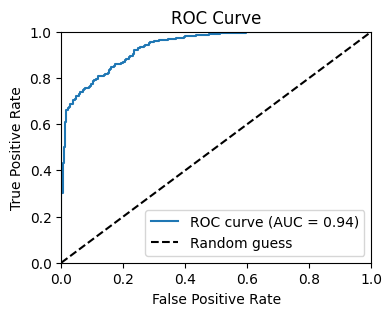

In [45]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Compute AUC score
roc_auc = roc_auc_score(test_labels, y_test_pred)
fpr, tpr, thresholds = roc_curve(test_labels, y_test_pred[:, 0])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()